In [1]:
# Ensure Python sees the project root for module imports
import os, sys
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

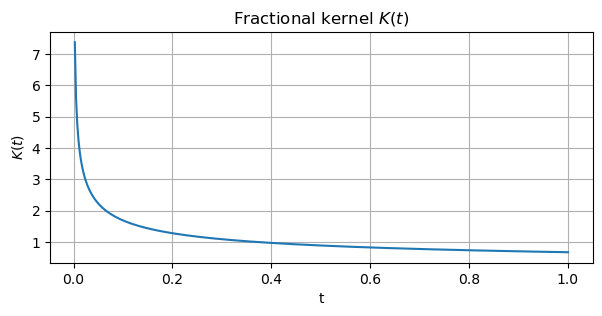

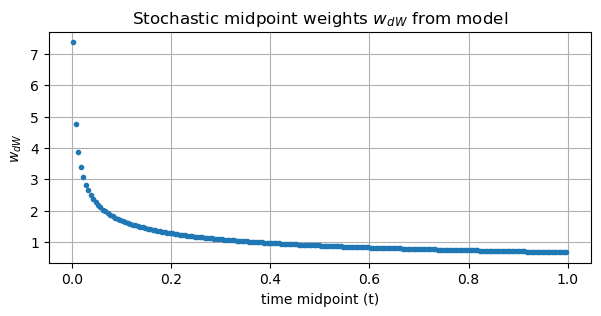

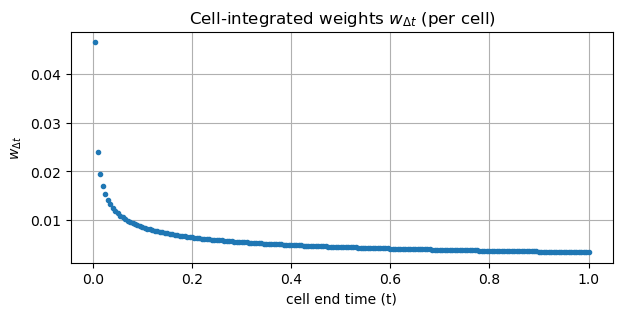

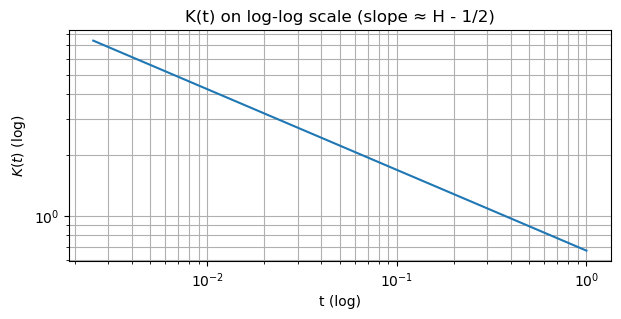

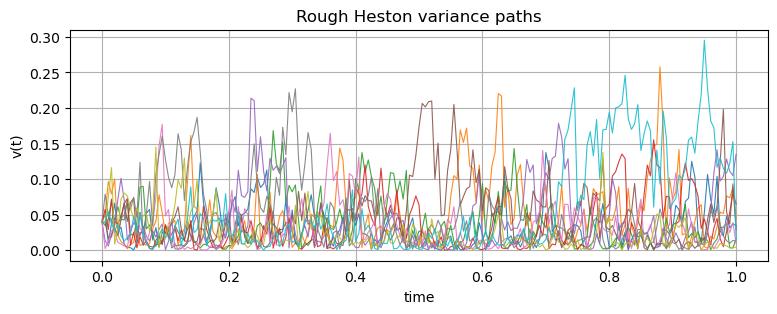

In [2]:
from models.rough_heston_volterra import RoughHestonVolterra
import numpy as np
import matplotlib.pyplot as plt

m = RoughHestonVolterra(
    v0=0.04, kappa=1.5, theta=0.05, xi=0.3, H=0.1,
    T=1.0, n_steps=200, n_paths=1500, seed=42, reflect=True 
)

res = m.generate_paths()
v = res["v"]; t = res["time"]
m.plot_kernel()
m.plot_midpoint_weights()
m.plot_cell_weights()
m.plot_kernel_loglog()
m.plot_paths(n_paths_to_show=10, res=res)



In [3]:
import numpy as np
v = np.zeros((m.n_paths, m.n_steps+1)); v[:,0] = m.v0
dW = m._draw_increments()

for i in range(1, 4):  # first 3 steps
    vi = v[:, :i]
    wdti = m.w_dt[:i][::-1]
    wdWi = m.w_dW[:i][::-1]
    phi = m.kappa * (m.theta - vi)
    det = phi @ wdti
    psi_dW = m.xi * np.sqrt(np.clip(vi, 1e-12, None)) * dW[:, :i]
    sto = psi_dW @ wdWi
    v[:, i] = m.v0 + det + sto
    v[:, i] = np.abs(v[:, i]) if m.reflect else np.maximum(v[:, i], m.eps_floor)
    print(f"i={i}  det(mean)={det.mean():.4e}  sto(mean)={sto.mean():.4e}  v(mean)={v[:, i].mean():.4e}")


i=1  det(mean)=6.9883e-04  sto(mean)=4.4409e-19  v(mean)=4.3610e-02
i=2  det(mean)=8.0698e-04  sto(mean)=1.3412e-05  v(mean)=4.3849e-02
i=3  det(mean)=9.5189e-04  sto(mean)=-2.1031e-04  v(mean)=4.4353e-02


In [4]:
print(m.reflect, m.eps_floor, m.xi, m.n_steps)


True 1e-12 0.3 200


In [5]:
v = res["v"]; t = res["time"]
for i in range(6):
    col = v[:, i]
    print(f"t={t[i]:.4f}  min={col.min():.3e}  med={np.median(col):.3e}  max={col.max():.3e}")


t=0.0000  min=4.000e-02  med=4.000e-02  max=4.000e-02
t=0.0050  min=1.387e-05  med=4.104e-02  max=1.517e-01
t=0.0100  min=2.625e-04  med=3.474e-02  max=1.902e-01
t=0.0150  min=4.591e-06  med=3.408e-02  max=2.204e-01
t=0.0200  min=1.918e-05  med=3.392e-02  max=2.817e-01
t=0.0250  min=3.568e-05  med=3.377e-02  max=2.891e-01


In [6]:
v = res["v"]; t = res["time"]
mean_emp = v.mean(axis=0)
mean_theo = m.theta + (m.v0 - m.theta) * np.exp(-m.kappa * t)
print(np.max(np.abs(mean_emp - mean_theo)))  # should be small (order of 1e-3 to 1e-2 depending on xi, steps)


0.008489813847768632
